In [27]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import metric_functions
from itertools import combinations
import cv2
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image, ImageOps
import glob

In [28]:
#VAR declarations
all_metrics =  ['ssim']
# maximum umber of frames to capture
#max_frames = 150
comparison_images = {}
keyframes = []


In [57]:
cap = cv2.VideoCapture('testvid.mov')
#cap = cv2.VideoCapture('testvid01.mov')
#Or most common ID for webcams:
#cap = cv2.VideoCapture(0)

In [58]:
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames per second using video.get(cv2.CAP_PROP_FPS) : {fps}")

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.029060381013885


In [59]:
frame_nr = 0
#ensure how to handle exeptions
#add all frames/framenames somewhere as we'l need them later
while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        # TODO: change the filename like ffmpeg ones if we split the video into images
        frame_name = f"frame_{frame_nr}.jpg" 
        #print(frame_name)
        #cv2.imwrite(f"frame{frame_nr}.jpg", frame)
        #i.e. at 30 fps, this advances one second
        #int(fps) for rounding
        frame_nr += int(fps)  
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr)
        comparison_images[frame_name] = frame
        #comparison_images.append(tuple([frame_name,frame]))
    else:
        cap.release()
        break


In [60]:
def compare(df: pd.DataFrame, img_name_a: str, img_name_b: str, img_a: np.ndarray, img_b: np.ndarray, metrics: List[str]) -> pd.DataFrame:
    for metric in metrics:
        metric_func = metric_functions[metric]
        start_time = time.time()
        out_value = float(metric_func(img_a, img_b))
        end_time = time.time()
        output_dict = {}
        output_dict['metric'] = metric
        output_dict['x'] = img_name_a
        output_dict['y'] = img_name_b
        output_dict['value'] = out_value
        output_dict['walltime'] = end_time - start_time
        df = df.append(output_dict,ignore_index=True)
        output_dict['y'] = img_name_a
        output_dict['x'] = img_name_b
        df = df.append(output_dict,ignore_index=True)
        
    return df


In [61]:
df = pd.DataFrame()
for pair in combinations(comparison_images.keys(), 2):
    print(pair)
    # *pair : instead handing over a tuple(a,b) , hand over each element as separate argument a,b
    df = compare(df, *pair, comparison_images[pair[0]], comparison_images[pair[1]], all_metrics)
#df

('frame_0.jpg', 'frame_30.jpg')
('frame_0.jpg', 'frame_60.jpg')
('frame_0.jpg', 'frame_90.jpg')
('frame_0.jpg', 'frame_120.jpg')
('frame_0.jpg', 'frame_150.jpg')
('frame_30.jpg', 'frame_60.jpg')
('frame_30.jpg', 'frame_90.jpg')
('frame_30.jpg', 'frame_120.jpg')
('frame_30.jpg', 'frame_150.jpg')
('frame_60.jpg', 'frame_90.jpg')
('frame_60.jpg', 'frame_120.jpg')
('frame_60.jpg', 'frame_150.jpg')
('frame_90.jpg', 'frame_120.jpg')
('frame_90.jpg', 'frame_150.jpg')
('frame_120.jpg', 'frame_150.jpg')


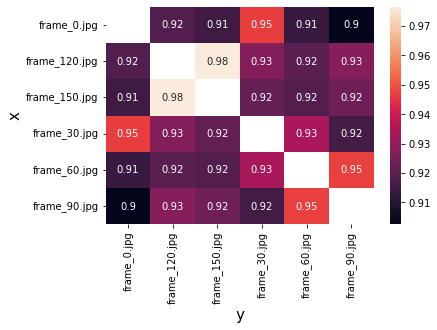

In [62]:
#Build some nice plots for better evaluation
#select one metric and pivot the dataframe for creating the heatmap plot
plot_df = df[df.metric == 'ssim'].pivot('x', 'y', 'value')
ax = sns.heatmap(plot_df, annot=True)


In [47]:
df.sort_values(by=['value'], ascending=True)

,metric,x,y,value,walltime
4,ssim,frame_0.jpg,frame_90.jpg,0.902481,0.756119
5,ssim,frame_90.jpg,frame_0.jpg,0.902481,0.756119
2,ssim,frame_0.jpg,frame_60.jpg,0.913602,0.787791
3,ssim,frame_60.jpg,frame_0.jpg,0.913602,0.787791
8,ssim,frame_0.jpg,frame_150.jpg,0.914823,0.757907
9,ssim,frame_150.jpg,frame_0.jpg,0.914823,0.757907
13,ssim,frame_90.jpg,frame_30.jpg,0.915621,0.761281
12,ssim,frame_30.jpg,frame_90.jpg,0.915621,0.761281
6,ssim,frame_0.jpg,frame_120.jpg,0.918158,0.755065
7,ssim,frame_120.jpg,frame_0.jpg,0.918158,0.755065


In [51]:
df["value"].min()


0.902480996061859

In [52]:
#Get rows with minimal values
df_tmp = df.loc[df["value"] == df["value"].min()]
df_tmp

,metric,x,y,value,walltime
4,ssim,frame_0.jpg,frame_90.jpg,0.902481,0.756119
5,ssim,frame_90.jpg,frame_0.jpg,0.902481,0.756119


In [53]:
#Get first row
df_tmp = df_tmp.iloc[0] 
df_tmp

metric              ssim
x            frame_0.jpg
y           frame_90.jpg
value           0.902481
walltime        0.756119
Name: 4, dtype: object

In [54]:
#Save our first two keyframes
keyframes.append(df_tmp['x'])
keyframes.append(df_tmp['y'])

In [55]:
#...and drop the rows
df = df.drop(df.loc[df["value"] == df["value"].min()].index)

In [56]:
df_tmp = df.loc[df["value"] == df["value"].min()]
df_tmp = df_tmp.iloc[0]
print(df_tmp)
keyframes.append(df_tmp['x'])
keyframes.append(df_tmp['y'])

metric              ssim
x            frame_0.jpg
y           frame_60.jpg
value           0.913602
walltime        0.787791
Name: 2, dtype: object


In [42]:
keyframes.sort()

In [43]:
#Get unique values
keyframes = list(set(keyframes))

In [44]:
keyframes

['frame_0.jpg', 'frame_60.jpg', 'frame_90.jpg']

In [19]:
comparison_images.keys()

dict_keys(['frame_0.jpg', 'frame_30.jpg', 'frame_60.jpg', 'frame_90.jpg', 'frame_120.jpg', 'frame_150.jpg'])

In [20]:
for img_name in keyframes:
    cv2.imwrite(img_name, comparison_images[img_name])

Display chosen keyframes

In [21]:
#chosen_keyframes = [ cv2.imread(img_name) for img_name in keyframes]

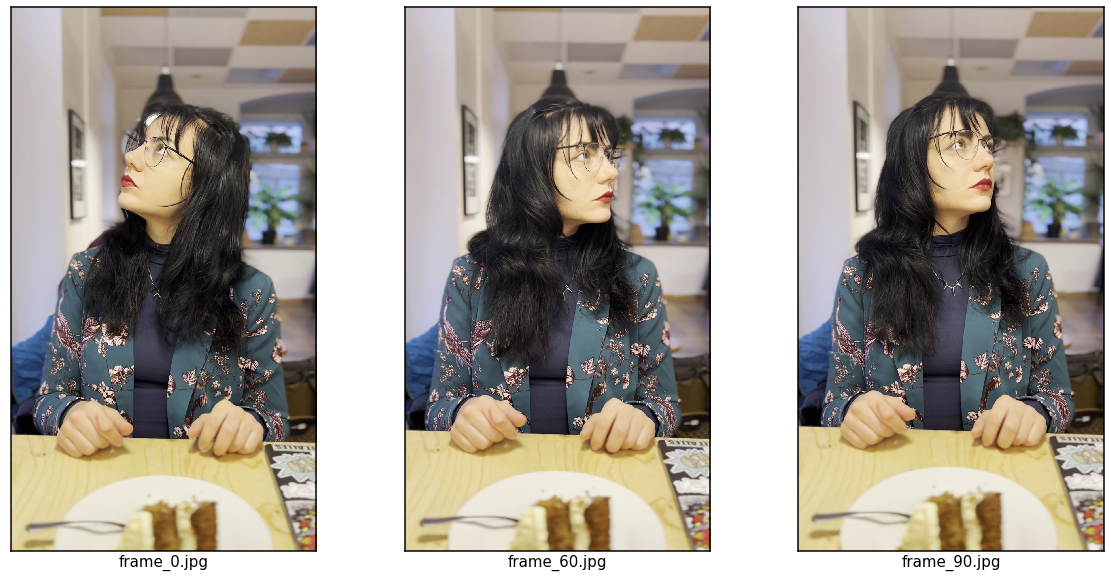

In [22]:
xlen = len(keyframes)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, img_path in zip(axes, keyframes):
    img = Image.open(img_path)
    isns.imgplot(img, ax=ax, cbar=False)
    ax.invert_yaxis()
    ax.set_xlabel(img_path)

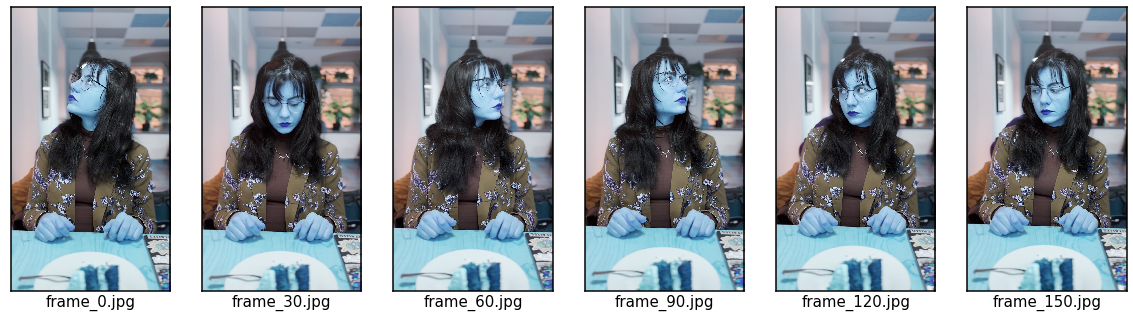

In [26]:
xlen = len(comparison_images)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, name in zip(axes, comparison_images.keys()):
    img = comparison_images[name]
    isns.imgplot(img, ax=ax, cbar=False)
    ax.invert_yaxis()
    ax.set_xlabel(name)